In [6]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import gc

In [2]:
# Function to read tif with rasterio
def read_tif(file_name):
    with rasterio.open(file_name) as src:
        im_data = src.read(1).astype('float32')
        im_data[im_data <= 0] = np.nan
        im_data[im_data == src.nodata] = np.nan  # Apply nodata mask
        im_Geotrans = src.transform
        im_proj = src.crs
    return im_data, im_Geotrans, im_proj, None, None

# Function to reproject tif to EPSG:3031
def reproject_to_epsg3031(src_path):
    dst_crs = "EPSG:3031"

    with rasterio.open(src_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        dst_array = np.empty((height, width), dtype=np.float32)

        reproject(
            source=rasterio.band(src, 1),
            destination=dst_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)

    return dst_array, transform, dst_crs

In [3]:
# Load shapefile and reproject
shapefile_path = r"G:\Hangkai\Antarctica_Mapping_Data\shapefile\shapefile_for_whole_continent\whole.shp"
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs("EPSG:3031")

In [3]:
# Load and reproject 2002 greenness data
file_path = r"G:\Hangkai\Antarctica_Mapping_Data\yearly_land_greenness\Duration_2002.tif"
im_data, im_Geotrans, im_proj, _, _ = read_tif(file_path)
im_data, im_Geotrans, im_proj = reproject_to_epsg3031(file_path)

In [6]:
# Create mask
im_data[im_data <= 0] = np.nan
mask = ~np.isnan(im_data)
height, width = im_data.shape

# Generate grid coordinates
x_coords = np.arange(0, width) * im_Geotrans.a + im_Geotrans.c
y_coords = np.arange(0, height) * im_Geotrans.e + im_Geotrans.f
xx, yy = np.meshgrid(x_coords, y_coords)
x_valid, y_valid, data_valid = xx[mask].flatten(), yy[mask].flatten(), im_data[mask].flatten()

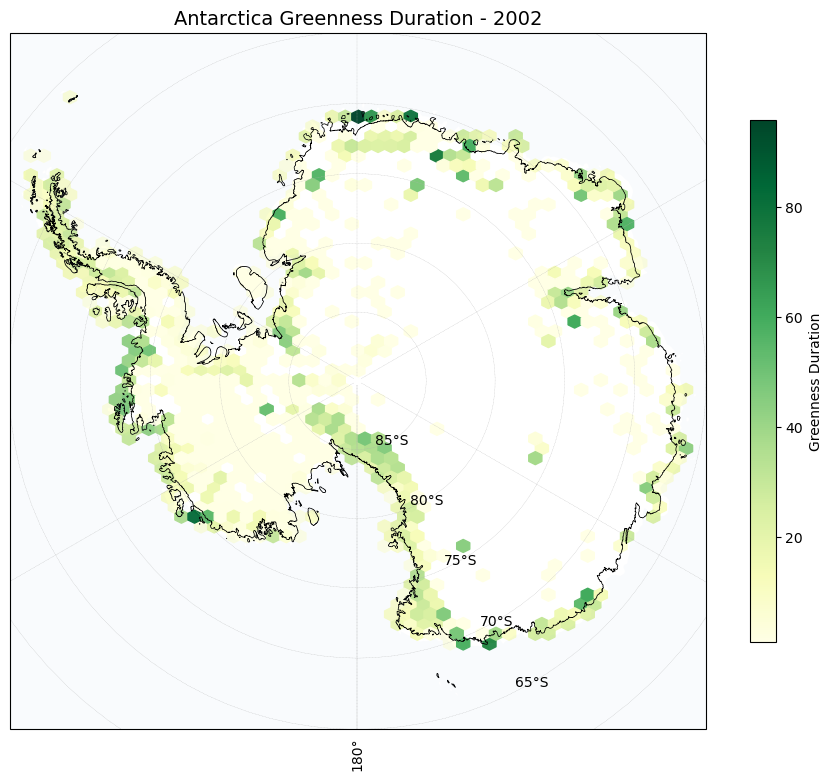

In [6]:
# Plotting
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={'projection': ccrs.SouthPolarStereo()}, dpi=100)

ax.set_extent([-180, 180, -90, -65], crs=ccrs.PlateCarree())
ax.add_feature(cf.OCEAN, alpha=0.05, zorder=2)
gl = ax.gridlines(draw_labels=True, dms=True, linestyle='--', linewidth=0.2)
gl.top_labels = False
gl.right_labels = False

# Plot hexbin
hb = ax.hexbin(x_valid, y_valid, C=data_valid, gridsize=50,
               transform=ccrs.SouthPolarStereo(), cmap='YlGn', reduce_C_function=np.nanmean)

# Plot the Antarctica shapefile boundary
ax.add_geometries(gdf.geometry, crs=ccrs.SouthPolarStereo(), edgecolor='black', facecolor='none', linewidth=0.5)

plt.title("Antarctica Greenness Duration - 2002", fontsize=14)
plt.colorbar(hb, ax=ax, shrink=0.6, label='Greenness Duration')
plt.tight_layout()
plt.show()

C:\Users\hyou34\AppData\Local\Temp\ipykernel_16032\869465650.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])  # leave space for colorbar


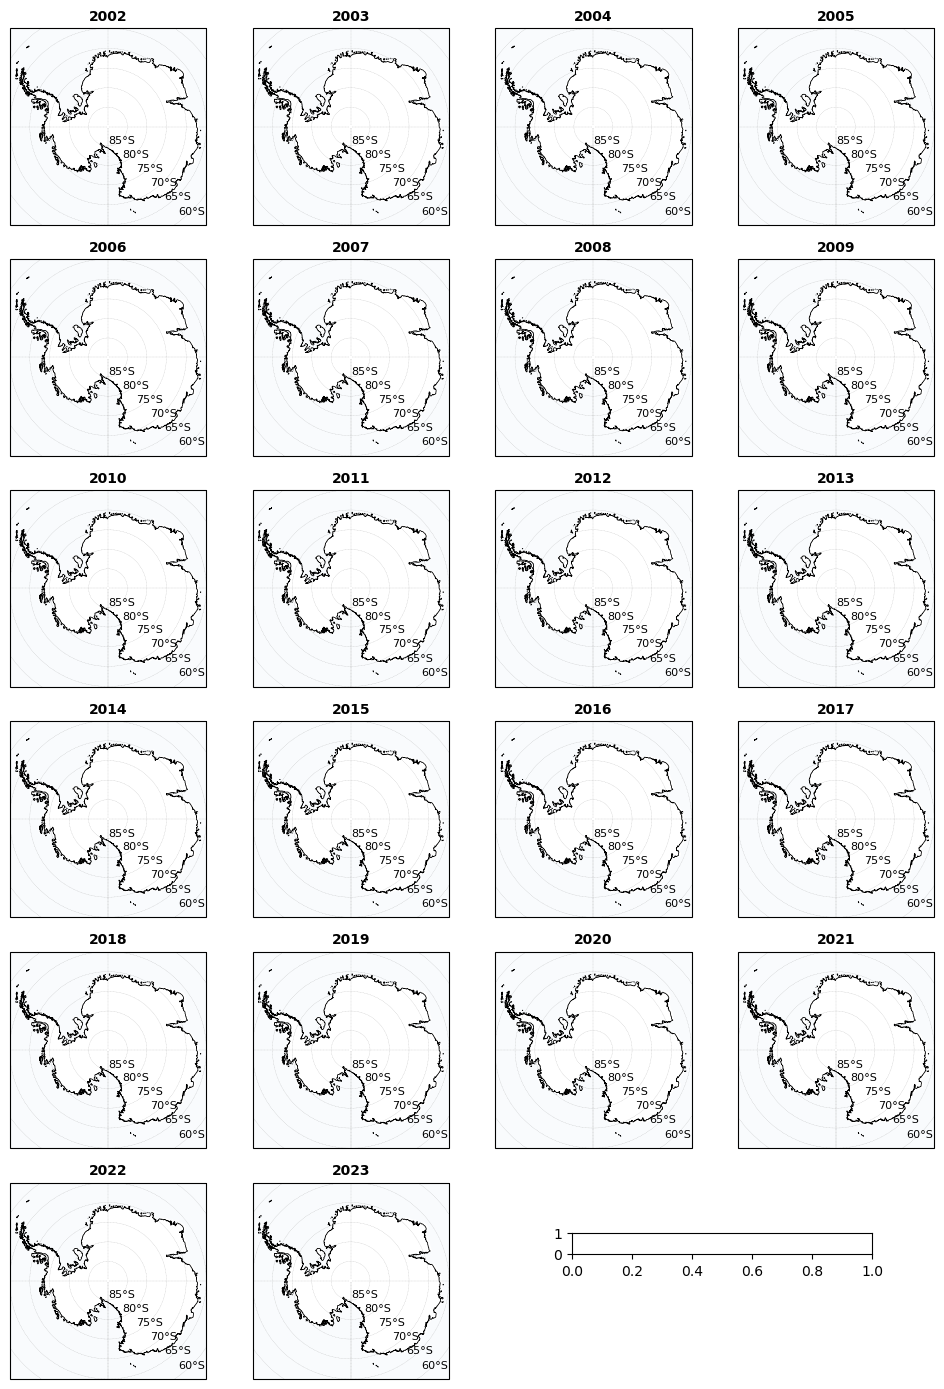

In [7]:
# Set up subplot grid
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(10, 14),
                         subplot_kw={'projection': ccrs.SouthPolarStereo()}, dpi=100)

years = list(range(2002, 2024))
vmin, vmax = 0, 100  # fixed colorbar range

# Loop through all years
for idx, year in enumerate(years):
    row, col = divmod(idx, 4)
    ax = axes[row][col]

    """
    file_path = fr"G:\Hangkai\Antarctica_Mapping_Data\yearly_land_greenness\Duration_{year}.tif"
    im_data, im_Geotrans, im_proj, _, _ = read_tif(file_path)
    im_data, im_Geotrans, im_proj = reproject_to_epsg3031(file_path)
    
    im_data[im_data <= 0] = np.nan
    mask = ~np.isnan(im_data)
    
    height, width = im_data.shape

    x_coords = np.arange(0, width) * im_Geotrans.a + im_Geotrans.c
    y_coords = np.arange(0, height) * im_Geotrans.e + im_Geotrans.f
    xx, yy = np.meshgrid(x_coords, y_coords)
    x_valid, y_valid, data_valid = xx[mask].flatten(), yy[mask].flatten(), im_data[mask].flatten()
    """

    ax.set_extent([-180, 180, -90, -65], crs=ccrs.PlateCarree())
    ax.add_feature(cf.OCEAN, alpha=0.05, zorder=1)
    ax.add_geometries(gdf.geometry, crs=ccrs.SouthPolarStereo(), edgecolor='black', facecolor='none', linewidth=0.5)
    """
    hb = ax.hexbin(x_valid, y_valid, C=data_valid, gridsize=50,
                   transform=ccrs.SouthPolarStereo(), cmap='YlGn', reduce_C_function=np.nanmean,
                   vmin=vmin, vmax=vmax)
    """
    ax.set_title(f"{year}", fontsize=10, fontweight='bold')
    gl = ax.gridlines(draw_labels=True, dms=True, linestyle='--',linewidth=0.2)
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = True
    gl.left_labels = True
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 90))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

# Hide the last two empty subplots
for idx in range(len(years), 6 * 4):
    row, col = divmod(idx, 4)
    axes[row][col].axis('off')
    
# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.6, 0.1, 0.3, 0.015])  # [left, bottom, width, height]
#cbar = fig.colorbar(hb, cax=cbar_ax)
#cbar.set_label('Greenness Duration')

plt.tight_layout(rect=[0, 0, 1, 1])  # leave space for colorbar
plt.show()

C:\Users\hyou34\AppData\Local\Temp\ipykernel_30288\3177907093.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])  # leave space for colorbar


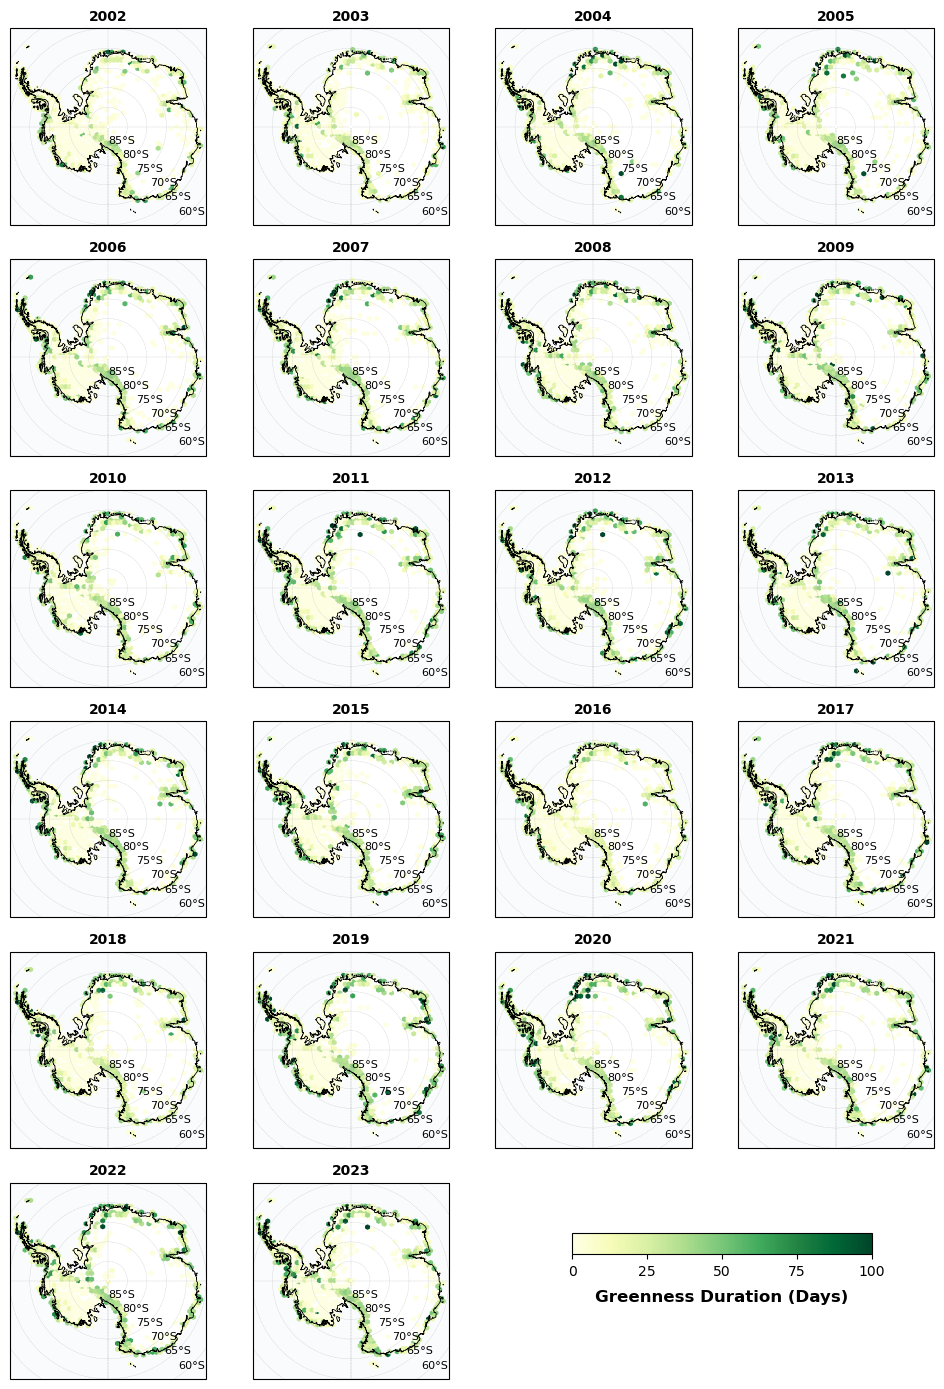

0

In [7]:
# Set up subplot grid
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(10, 14),
                         subplot_kw={'projection': ccrs.SouthPolarStereo()}, dpi=100)

years = list(range(2002, 2024))
vmin, vmax = 0, 100  # fixed colorbar range

# Loop through all years
for idx, year in enumerate(years):
    row, col = divmod(idx, 4)
    ax = axes[row][col]

    file_path = fr"G:\Hangkai\Antarctica_Mapping_Data\yearly_land_greenness\Duration_{year}.tif"
    im_data, im_Geotrans, im_proj, _, _ = read_tif(file_path)
    im_data, im_Geotrans, im_proj = reproject_to_epsg3031(file_path)
    
    im_data[im_data <= 0] = np.nan
    mask = ~np.isnan(im_data)
    
    height, width = im_data.shape

    x_coords = np.arange(0, width) * im_Geotrans.a + im_Geotrans.c
    y_coords = np.arange(0, height) * im_Geotrans.e + im_Geotrans.f
    xx, yy = np.meshgrid(x_coords, y_coords)
    x_valid, y_valid, data_valid = xx[mask].flatten(), yy[mask].flatten(), im_data[mask].flatten()

    ax.set_extent([-180, 180, -90, -65], crs=ccrs.PlateCarree())
    ax.add_feature(cf.OCEAN, alpha=0.05, zorder=1)
    ax.add_geometries(gdf.geometry, crs=ccrs.SouthPolarStereo(), edgecolor='black', facecolor='none', linewidth=0.5)
    
    hb = ax.hexbin(x_valid, y_valid, C=data_valid, gridsize=50,
                   transform=ccrs.SouthPolarStereo(), cmap='YlGn', reduce_C_function=np.nanmean,
                   vmin=vmin, vmax=vmax)
    
    ax.set_title(f"{year}", fontsize=10, fontweight='bold')
    gl = ax.gridlines(draw_labels=True, dms=True, linestyle='--',linewidth=0.2)
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = True
    gl.left_labels = True
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 90))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

# Hide the last two empty subplots
for idx in range(len(years), 6 * 4):
    row, col = divmod(idx, 4)
    axes[row][col].axis('off')
    
# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.6, 0.1, 0.3, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal')
cbar.set_ticks([0, 25, 50, 75, 100])
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Greenness Duration (Days)', fontsize=12, fontweight='bold', labelpad=8)

plt.tight_layout(rect=[0, 0, 1, 1])  # leave space for colorbar
plt.show()

del im_Geotrans, im_proj
del rows, cols, x_valid, y_valid, data_valid
del hb
gc.collect()

C:\Users\hyou34\AppData\Local\Temp\ipykernel_30288\1277373072.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])  # leave space for colorbar


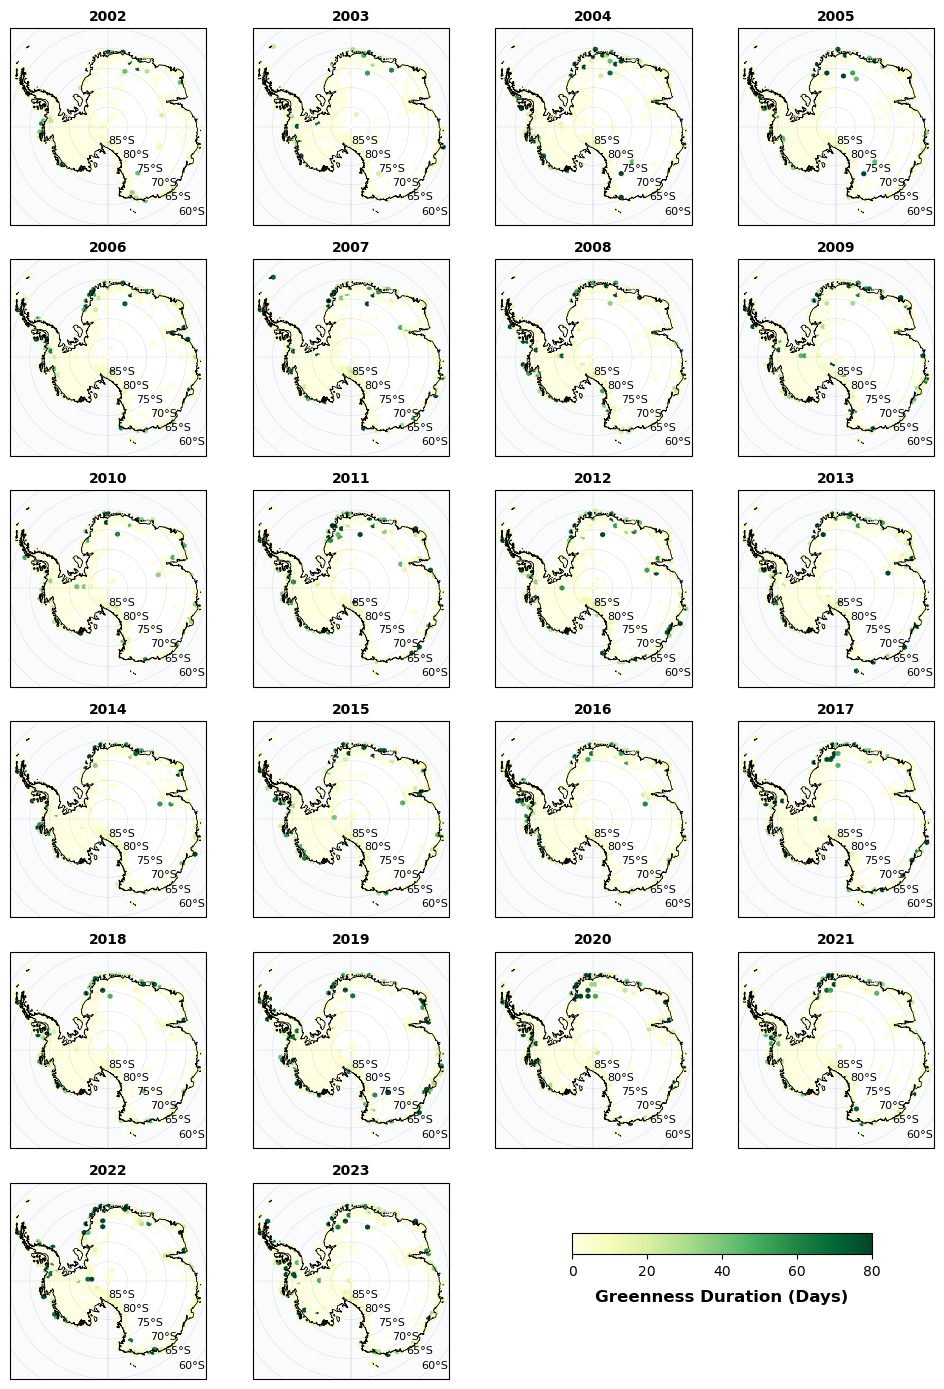

0

In [10]:
# Set up subplot grid
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(10, 14),
                         subplot_kw={'projection': ccrs.SouthPolarStereo()}, dpi=100)

years = list(range(2002, 2024))
vmin, vmax = 0, 80  # fixed colorbar range

# Loop through all years
for idx, year in enumerate(years):
    row, col = divmod(idx, 4)
    ax = axes[row][col]

    file_path = fr"G:\Hangkai\Antarctica_Mapping_Data\yearly_land_greenness\Duration_{year}.tif"
    im_data, im_Geotrans, im_proj, _, _ = read_tif(file_path)
    im_data, im_Geotrans, im_proj = reproject_to_epsg3031(file_path)
    
    im_data[im_data <= 0] = np.nan
    mask = ~np.isnan(im_data)
    
    height, width = im_data.shape

    x_coords = np.arange(0, width) * im_Geotrans.a + im_Geotrans.c
    y_coords = np.arange(0, height) * im_Geotrans.e + im_Geotrans.f
    xx, yy = np.meshgrid(x_coords, y_coords)
    x_valid, y_valid, data_valid = xx[mask].flatten(), yy[mask].flatten(), im_data[mask].flatten()

    ax.set_extent([-180, 180, -90, -65], crs=ccrs.PlateCarree())
    ax.add_feature(cf.OCEAN, alpha=0.05, zorder=1)
    ax.add_geometries(gdf.geometry, crs=ccrs.SouthPolarStereo(), edgecolor='black', facecolor='none', linewidth=0.5)
    
    hb = ax.hexbin(x_valid, y_valid, C=data_valid, gridsize=50,
                   transform=ccrs.SouthPolarStereo(), cmap='YlGn', reduce_C_function=np.nanmedian,
                   vmin=vmin, vmax=vmax)
    
    ax.set_title(f"{year}", fontsize=10, fontweight='bold')
    gl = ax.gridlines(draw_labels=True, dms=True, linestyle='--',linewidth=0.2)
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = True
    gl.left_labels = True
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 90))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

# Hide the last two empty subplots
for idx in range(len(years), 6 * 4):
    row, col = divmod(idx, 4)
    axes[row][col].axis('off')
    
# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.6, 0.1, 0.3, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal')
cbar.set_ticks([0, 20, 40, 60, 80])
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Greenness Duration (Days)', fontsize=12, fontweight='bold', labelpad=8)

plt.tight_layout(rect=[0, 0, 1, 1])  # leave space for colorbar
plt.show()

del im_Geotrans, im_proj
del x_valid, y_valid, data_valid
del hb
gc.collect()

C:\Users\hyou34\AppData\Local\Temp\ipykernel_30288\3222107608.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])  # leave space for colorbar


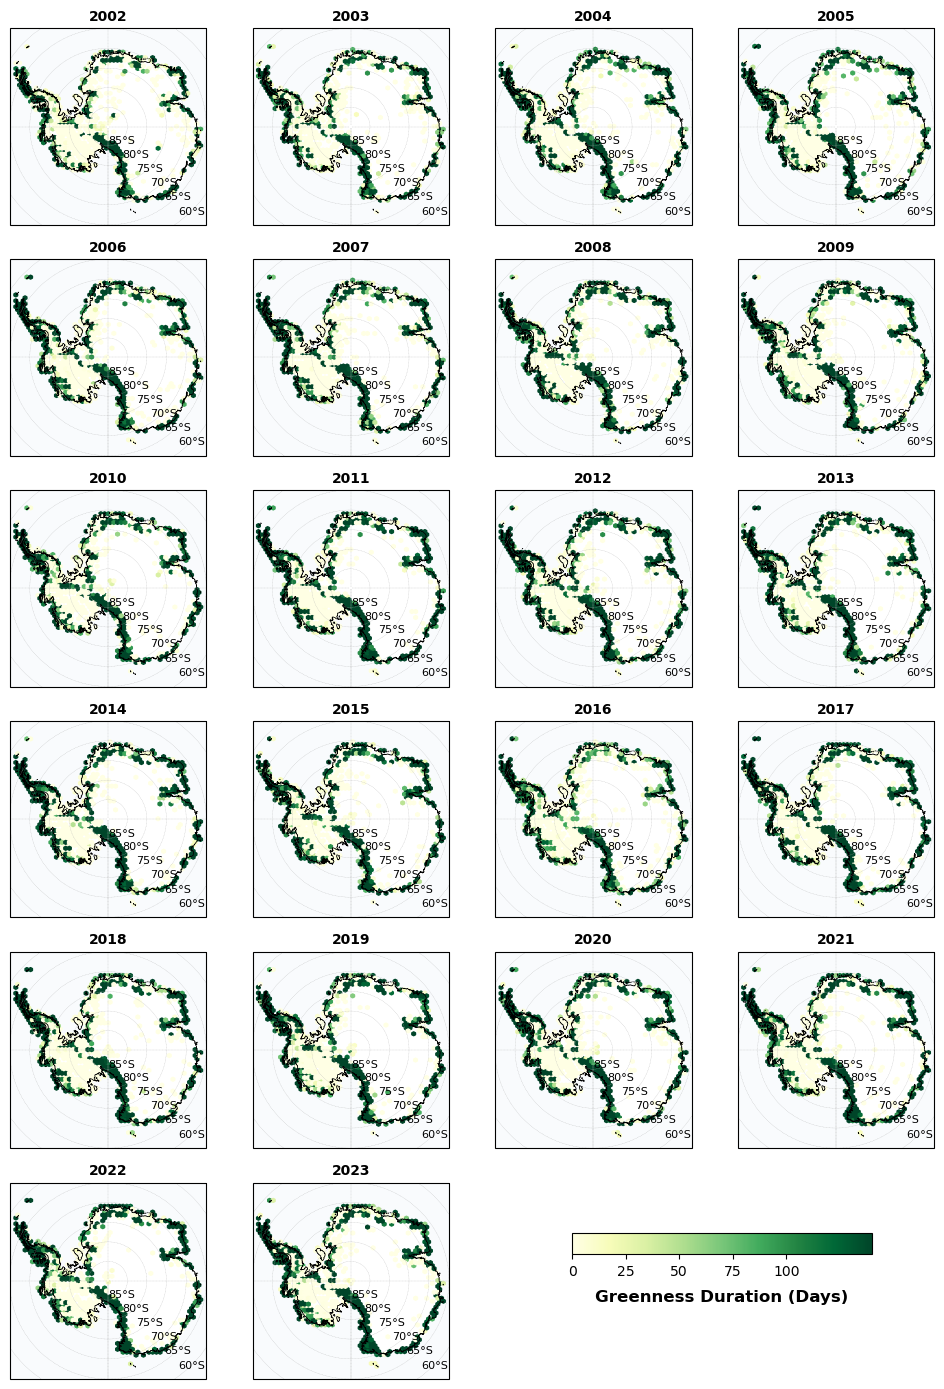

0

In [11]:
# Set up subplot grid
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(10, 14),
                         subplot_kw={'projection': ccrs.SouthPolarStereo()}, dpi=100)

years = list(range(2002, 2024))
vmin, vmax = 0, 140  # fixed colorbar range

# Loop through all years
for idx, year in enumerate(years):
    row, col = divmod(idx, 4)
    ax = axes[row][col]

    file_path = fr"G:\Hangkai\Antarctica_Mapping_Data\yearly_land_greenness\Duration_{year}.tif"
    im_data, im_Geotrans, im_proj, _, _ = read_tif(file_path)
    im_data, im_Geotrans, im_proj = reproject_to_epsg3031(file_path)
    
    im_data[im_data <= 0] = np.nan
    mask = ~np.isnan(im_data)
    
    height, width = im_data.shape

    x_coords = np.arange(0, width) * im_Geotrans.a + im_Geotrans.c
    y_coords = np.arange(0, height) * im_Geotrans.e + im_Geotrans.f
    xx, yy = np.meshgrid(x_coords, y_coords)
    x_valid, y_valid, data_valid = xx[mask].flatten(), yy[mask].flatten(), im_data[mask].flatten()

    ax.set_extent([-180, 180, -90, -65], crs=ccrs.PlateCarree())
    ax.add_feature(cf.OCEAN, alpha=0.05, zorder=1)
    ax.add_geometries(gdf.geometry, crs=ccrs.SouthPolarStereo(), edgecolor='black', facecolor='none', linewidth=0.5)
    
    hb = ax.hexbin(x_valid, y_valid, C=data_valid, gridsize=50,
                   transform=ccrs.SouthPolarStereo(), cmap='YlGn', reduce_C_function=np.nanmax,
                   vmin=vmin, vmax=vmax)
    
    ax.set_title(f"{year}", fontsize=10, fontweight='bold')
    gl = ax.gridlines(draw_labels=True, dms=True, linestyle='--',linewidth=0.2)
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = True
    gl.left_labels = True
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 90))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

# Hide the last two empty subplots
for idx in range(len(years), 6 * 4):
    row, col = divmod(idx, 4)
    axes[row][col].axis('off')
    
# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.6, 0.1, 0.3, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal')
cbar.set_ticks([0, 25, 50, 75, 100])
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Greenness Duration (Days)', fontsize=12, fontweight='bold', labelpad=8)

plt.tight_layout(rect=[0, 0, 1, 1])  # leave space for colorbar
plt.show()

del im_Geotrans, im_proj
del x_valid, y_valid, data_valid
del hb
gc.collect()